In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import optim
import torch.nn as nn
from torch.nn import functional as F

import sys
sys.path.insert(1,"src")

from IPython.display import clear_output
from IPython.core.debugger import set_trace

from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import copy
import math

import dlc_practical_prologue as dl
from opt import (
    Net2,
    train_model,
    get_accuracy,
    Kfold_CV,
    Naive,
    WeightAux,
    get_double_accuracy,
    train_double_model,
    Kfold_CVdouble,
)
from misc_funcs import RANDOM_SEED, EXPLORE_K, BIG_K, NB_EPOCHS, sep
N_SAMPLES = 500


In [1]:
import torch.nn as nn

In [ ]:
nn.L1Loss

# WeightAux

The project respects the following structure:
Simple Network:
```
    .
    ├── Simple Network               
    │   ├── Net2    
    │   ├── get_accuracy()         
    │   ├── train_model()  
    │   ├── Kfold_CV()
    ├── Double Network
    │   ├── Naive
    │   ├── WeightAux
    │   ├── accuracy_double_model()   
    │   ├── train_double_model()   
    │   ├── Kfold_CVdouble()

```

In [3]:
train_input, train_target, test_input, test_target = dl.load_data(flatten=False)
train_input = torch.functional.F.avg_pool2d(train_input, kernel_size=2)
test_input = torch.functional.F.avg_pool2d(test_input, kernel_size=2)

## Simple Network Implementation

<div class="alert alert-block alert-info">
We start by implementing a simple handmade-optimized CNN that performs decently on the MNIST dataset (nets.Net2): we will use it as the reference throuhghout the project for comparison purposes.
</div>

In [4]:
model = Net2()
architecture = Net2
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam
lr = 1e-3
train_model(train_input,train_target,model,criterion=criterion,optimizer=optimizer,lr=lr,verbose=True)
print(sep)
_ = get_accuracy(model, train_input, train_target, "Train")
_ = get_accuracy(model, test_input, test_target, "Test")
print(sep)

Progression:96.00 %
--------------------
Train accuracy: 1.00
Test accuracy: 0.95
--------------------


<div class="alert alert-block alert-info">
As we can see, the model overfits on the train set and performs well enough for the comparison purpose, although some parameter tuning could probably get this accuracy higher.
</div>

<div class="alert alert-block alert-info">
In order to get more robust estimates, a KFold Cross validation method was implemented as well
</div>

In [5]:
accuracies = Kfold_CV(train_input, train_target, architecture, criterion, optimizer, lr, K=BIG_K, verbose=True)

--------------------
Accuracies for 10-fold:[0.9399999976158142, 0.949999988079071, 0.949999988079071, 0.9399999976158142, 0.9200000166893005, 0.949999988079071, 0.9599999785423279, 0.9599999785423279, 0.9399999976158142, 0.9800000190734863]
Accuracy:0.95 +- 0.02
--------------------


## Dealing with double Images

<div class="alert alert-block alert-info">
We now implement 4 different model architectures in order to assess the performance improvement that can be achieved through weight sharing or auxiliary loss. 
    
* Naive model, where we just train 2 networks in parallel and trivially compare the output
* Weight Sharing (Model 1)
* Auxiliary loss (Model 2)
* No extension (Model 3)
* Auxiliary loss + Weight sharing (Model 4)
</div>

In [13]:
a, b, c, d = dl.load_data(flatten=False)
train2_input, train2_target, train2_classes = dl.mnist_to_pairs(N_SAMPLES, a, b)
test2_input, test2_target, test2_classes = dl.mnist_to_pairs(N_SAMPLES, c, d)

### Models

<div class="alert alert-block alert-info">
We first get a first feeling by optimizing the double network by hand....
</div>

### Implementations

<div class="alert alert-block alert-info">
Firs the naive model:
</div>

In [7]:
# Parameters definition
crit_comp = nn.CrossEntropyLoss
crit_class = nn.CrossEntropyLoss
optimizer = optim.Adam
lr = 1e-3
naive_baseline = Naive()
############################

In [9]:
train_double_model(train2_input,train2_target,train2_classes,naive_baseline,
                   crit_comp,crit_class,optimizer,lr,nb_epochs=NB_EPOCHS,verbose=True,prog_bar=True)
print(sep + "Train" + sep)
_ = get_double_accuracy(naive_baseline, train2_input, train2_target, train2_classes, verbose=True)
print(sep + "Test" + sep)
_ = get_double_accuracy(naive_baseline, test2_input, test2_target, test2_classes, verbose=True)

Progression:96.00 %
--------------------Train--------------------
Accuracy 1st Network:    1.00   
Accuracy 2nd Network:    1.00   
Accuracy comparison:     1.00    
--------------------Test--------------------
Accuracy 1st Network:    0.92   
Accuracy 2nd Network:    0.91   
Accuracy comparison:     0.94    


<div class="alert alert-block alert-info">
More robust metric thanks to KFold cross validation
</div>

In [10]:
_ = Kfold_CVdouble(train2_input,train2_target,train2_classes,
                   Naive(),crit_comp,crit_class,optimizer,lr,K=BIG_K,verbose=True,prog_bar=True)

--------------------Validation Accuracies for 10-fold:--------------------
Accuracy 1st network: 0.92 +- 0.04
Accuracy 2nd network: 0.95 +- 0.03
Accuracy comparison:  0.96 +- 0.03


<div class="alert alert-block alert-info">
And we proceed similarly for the weight sharing
</div>

In [11]:
# Parameters definition
crit_comp = nn.CrossEntropyLoss
crit_class = nn.CrossEntropyLoss
optimizer = optim.Adam
lr = 1e-3
lambda_ = 0.75
net2 = WeightAux(True, True)
############################

In [12]:
train_double_model(train2_input,train2_target,train2_classes,
                   net2,crit_comp,crit_class,optimizer,lr,lambda_,nb_epochs=NB_EPOCHS,verbose=True,prog_bar=False)
print(sep + "Train accuracy:" + sep)
_ = get_double_accuracy(
    net2, train2_input, train2_target, train2_classes, verbose=True
)
print(sep + "Test accuracy:" + sep)
_ = get_double_accuracy(net2, test2_input, test2_target, test2_classes, verbose=True)

--------------------Train accuracy:--------------------
Accuracy 1st Network:    1.00   
Accuracy 2nd Network:    1.00   
Accuracy comparison:     1.00    
--------------------Test accuracy:--------------------
Accuracy 1st Network:    0.95   
Accuracy 2nd Network:    0.93   
Accuracy comparison:     0.86    


In [13]:
acc_list = Kfold_CVdouble(train2_input,train2_target,train2_classes,WeightAux(True, True),crit_comp,
                          crit_class,optimizer,lr,lambda_,K=2,verbose=True,prog_bar=True)

--------------------Validation Accuracies for 2-fold:--------------------
Accuracy 1st network: 0.92 +- 0.01
Accuracy 2nd network: 0.92 +- 0.02
Accuracy comparison:  0.82 +- 0.02


# Hyperparameter Optimization

<div class="alert alert-block alert-info">
In order to improve the models mentionned above 2 types of hyperparameters optimization method were implemented:
    
* Grid Search
* Genetic Algorithm
    
Both of these methods rely on the following param class which allow intuitive subsequent optimization.
</div>

In [6]:
# local
from hyperopt import Param, HyperGrid, GetNTop, GetMax
from gridsearch import GridSearch

In [6]:
# 1 Architecture
Archis = [
    WeightAux(True, True),
    WeightAux(True, False),
    WeightAux(False, True),
    WeightAux(False, False),
]
# 2 Comparison Loss Function
CompLoss = [nn.CrossEntropyLoss, nn.NLLLoss, nn.MSELoss,nn.L1Loss]
# 3 Class Loss Functions
ClassLoss = [nn.CrossEntropyLoss, nn.NLLLoss, nn.MSELoss,nn.L1Loss]
# 4 Optimizers
Optimizers = [optim.SGD, optim.Adam, optim.Adagrad, optim.AdamW]
# 5 Learning Rates
LRs = [1e-4, 1e-3, 1e-2, 1e-1, 1]
# 6 Ratios
Lambdas = [0.2, 0.4, 0.7, 0.9]
HYPER_PARAMS = [Archis, CompLoss,ClassLoss, Optimizers, LRs, Lambdas]

## Grid Search Model

In [8]:
path= Path("./results/HYPERPARAM.pkl")
if path.exists():
    print("loading the existing HyperGrid")
    HG = torch.load(path)
else: 
    HG = HyperGrid(*HYPER_PARAMS, "./results/HYPERPARAM.pkl")

loading the existing HyperGrid


In [60]:
HG = HyperGrid(*HYPER_PARAMS, "./results/HYPERPARAM.pkl")

HG.estimate_time(train2_input, train2_target, train2_classes, K=2)


2.0 hours, 3.0 minutes


In [63]:
%%time
GridSearch(HG,train2_input,train2_target,train2_classes,K=2)

Grid Search progression: 99.98 %
Grid Search done! Hyperparam saved.
CPU times: user 12h 21min 56s, sys: 13min 38s, total: 12h 35min 34s
Wall time: 6h 36min 12s


## Grid Search Model Naive

In [69]:
HYPER_PARAMS_NAIVE = [[Naive()], [nn.CrossEntropyLoss],ClassLoss, Optimizers, LRs, [0]]
HG_naive = HyperGrid(*HYPER_PARAMS_NAIVE, "./results/HYPERPARAM_naive.pkl")

In [4]:
path= Path("./results/HYPERPARAM_naive.pkl")
if path.exists():
    print("loading the existing HyperGrid")
    HG_naive = torch.load(path)
else: 
    HG_naive = HyperGrid(*HYPER_PARAMS, path)

loading the existing HyperGrid


In [70]:
GridSearch(HG_naive,train2_input,train2_target,train2_classes)

Grid Search progression: 98.75 %
Grid Search done! Hyperparam saved.


## Grid Search Analysis

In [9]:
N_TOP = 3
naive_res  = GetNTop(HG_naive.lin_view(),N_TOP)
model1_res = GetNTop([i for i in HG.lin_view() if "_Weightshare_" in str(i)],N_TOP)
model2_res = GetNTop([i for i in HG.lin_view() if "_Auxloss_" in str(i)],N_TOP)
model3_res = GetNTop([i for i in HG.lin_view() if "_classic_" in str(i)],N_TOP)
model4_res = GetNTop([i for i in HG.lin_view() if "_WeightshareAuxloss_" in str(i)],N_TOP)

### Naive

In [17]:
naive_res

[NaiveArch_CrossEntropyLoss_CrossEntropyLoss_AdamW_0.01_0_#ind#_-1.00_#score#_0.95,
 NaiveArch_CrossEntropyLoss_CrossEntropyLoss_Adam_0.01_0_#ind#_-1.00_#score#_0.96,
 NaiveArch_CrossEntropyLoss_CrossEntropyLoss_Adagrad_0.01_0_#ind#_-1.00_#score#_0.94]

In [18]:
_ = naive_res[0].KFold(train2_input,train2_target,train2_classes,K=BIG_K,verbose=True,prog_bar=True)

--------------------Validation Accuracies for 10-fold:--------------------
Accuracy 1st network: 0.93 +- 0.04
Accuracy 2nd network: 0.94 +- 0.03
Accuracy comparison:  0.95 +- 0.02


### Model1

In [32]:
model1_res

[Arch_Weightshare_CrossEntropyLoss_L1Loss_Adagrad_0.001_0.9_#ind#_-1.00_#score#_0.82,
 Arch_Weightshare_CrossEntropyLoss_L1Loss_Adagrad_0.001_0.7_#ind#_-1.00_#score#_0.81,
 Arch_Weightshare_CrossEntropyLoss_L1Loss_Adagrad_0.001_0.4_#ind#_-1.00_#score#_0.81]

In [33]:
_ = model1_res[0].KFold(train2_input,train2_target,train2_classes,K=BIG_K,verbose=True,prog_bar=True)

--------------------Validation Accuracies for 10-fold:--------------------
Accuracy 1st network: 0.13 +- 0.06
Accuracy 2nd network: 0.11 +- 0.04
Accuracy comparison:  0.82 +- 0.05


### Model2

In [21]:
model2_res

[Arch_Auxloss_L1Loss_CrossEntropyLoss_AdamW_0.01_0.2_#ind#_-1.00_#score#_0.87,
 Arch_Auxloss_MSELoss_CrossEntropyLoss_AdamW_0.01_0.2_#ind#_-1.00_#score#_0.86,
 Arch_Auxloss_MSELoss_CrossEntropyLoss_Adagrad_0.01_0.2_#ind#_-1.00_#score#_0.86]

In [22]:
_ = model2_res[0].KFold(train2_input,train2_target,train2_classes,K=BIG_K,verbose=True,prog_bar=True)

--------------------Validation Accuracies for 10-fold:--------------------
Accuracy 1st network: 0.93 +- 0.06
Accuracy 2nd network: 0.94 +- 0.04
Accuracy comparison:  0.90 +- 0.03


### Model3

In [23]:
model3_res

[Arch_classic_MSELoss_L1Loss_Adagrad_0.01_0.9_#ind#_-1.00_#score#_0.82,
 Arch_classic_MSELoss_L1Loss_Adagrad_0.01_0.7_#ind#_-1.00_#score#_0.82,
 Arch_classic_MSELoss_L1Loss_Adagrad_0.01_0.4_#ind#_-1.00_#score#_0.82]

In [24]:
_ = model3_res[0].KFold(train2_input,train2_target,train2_classes,K=BIG_K,verbose=True,prog_bar=True)

--------------------Validation Accuracies for 10-fold:--------------------
Accuracy 1st network: 0.11 +- 0.04
Accuracy 2nd network: 0.14 +- 0.09
Accuracy comparison:  0.79 +- 0.05


### Model4

In [25]:
model4_res

[Arch_WeightshareAuxloss_L1Loss_CrossEntropyLoss_Adam_0.01_0.2_#ind#_-1.00_#score#_0.87,
 Arch_WeightshareAuxloss_MSELoss_CrossEntropyLoss_Adagrad_0.01_0.2_#ind#_-1.00_#score#_0.87,
 Arch_WeightshareAuxloss_MSELoss_CrossEntropyLoss_Adam_0.01_0.2_#ind#_-1.00_#score#_0.87]

In [26]:
_  = model4_res[0].KFold(train2_input,train2_target,train2_classes,K=BIG_K,verbose=True,prog_bar=True)

--------------------Validation Accuracies for 10-fold:--------------------
Accuracy 1st network: 0.95 +- 0.04
Accuracy 2nd network: 0.95 +- 0.03
Accuracy comparison:  0.91 +- 0.04


## Genetic Algorithm

In [27]:
from genetic import (
    generate_population,
    compute_individuality,
    compute_fitness,
    selection,
    breed,
    plot_population,
)

In [28]:
Param.set_hyper_params(HYPER_PARAMS)

* START<br>
    - Generate the initial population<br>
    - Compute fitness<br>
* REPEAT<br>
    - Selection<br>
    - Crossover<br>
    - Mutation<br>
    - Compute fitness<br>
* UNTIL population has converged<br>
* STOP<br>

Assumption: complex : hill climbing algorithm might get stuck in.

Population Progression: 96.66666666666667 %


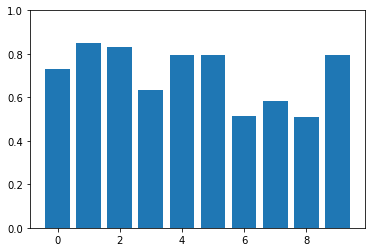

CPU times: user 37min 42s, sys: 41.7 s, total: 38min 24s
Wall time: 19min 36s


In [29]:
%%time
####################################
# size of the population
N_POP = 10
# number of iteration of selection
N_ITER = 30
# selection ratio
SELEC_RATIO = 0.6
# chance of mutation
CHANCE = 0.1
# number of fold for evaluation
K = 3
####################################

# we keep a param to receive
best_indiv = Param()
# initial population
population = generate_population(N_POP)
compute_fitness(
    train2_input, train2_target, train2_classes, population, K=K, verbose=True
)
compute_individuality(population)
for i in range(N_ITER):
    clear_output(wait=False)
    print("Population Progression: {} %".format(i / N_ITER * 100))
    plot_population(population)
    plt.pause(0.05)
    population = selection(population, selec_ratio=SELEC_RATIO)
    if population[0].score_mean > best_indiv.score_mean:
        best_indiv = population[0]
    population = breed(population, n_pop=N_POP, chance=CHANCE)
    compute_fitness(train2_input, train2_target, train2_classes, population, K=K)
    compute_individuality(population)
    torch.save(population,"./results/GEN_ALG.pickle", pickle_module=pickle)

<div class="alert alert-block alert-info">
Once again, we compute the score on a bigger K-fold for consistent results
</div>

In [27]:
population = torch.load("./results/GEN_ALG.pickle", pickle_module=pickle)

In [28]:
gen_res = GetNTop(population,N_TOP)

In [29]:
gen_res

[Arch_WeightshareAuxloss_L1Loss_CrossEntropyLoss_AdamW_0.001_0.7_#ind#_0.26_#score#_0.85,
 Arch_WeightshareAuxloss_CrossEntropyLoss_CrossEntropyLoss_Adam_0.001_0.7_#ind#_0.07_#score#_0.83,
 Arch_Weightshare_CrossEntropyLoss_CrossEntropyLoss_Adam_0.001_0.7_#ind#_0.00_#score#_0.79]

In [31]:
_ = gen_res[0].KFold(train2_input,train2_target,train2_classes,K=BIG_K,verbose=True,prog_bar=True)

--------------------Validation Accuracies for 10-fold:--------------------
Accuracy 1st network: 0.93 +- 0.04
Accuracy 2nd network: 0.94 +- 0.04
Accuracy comparison:  0.87 +- 0.04
